In [1]:
%pylab inline
import json
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
import sklearn
import pandas as pd
from typing import Tuple
from typing import List

dataset = pd.read_csv('synchronized-eeg.csv',
                      parse_dates=['indra_time'],
                      index_col='indra_time')
# convert to arrays from strings
dataset.raw_values = dataset.raw_values.map(json.loads)

#LAB1: load raw eeg values
dataset.eeg_power = dataset.eeg_power.map(json.loads)

Populating the interactive namespace from numpy and matplotlib


ModuleNotFoundError: No module named 'xgboost'

# 1. EEG

Neurons produce electrical activity in the brain.

If we zoom out far enough (and, for our purposes, we must), these neuronal firings appear most clearly as patterns of constructive or destructive interference. They are typically low-frequency waves, 0.5Hz-70Hz.

But, don't take my word for it. Let's open up a signal from our corpus.

Here's 512 readings, or one second, of the 30,000 seconds in our dataset. Let's take the 100th reading in our dataset:

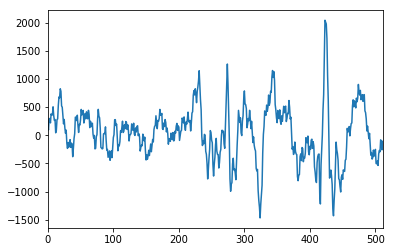

In [6]:
pd.Series(dataset.raw_values[100].values).plot()

This is *time-domain* data. It represents voltages over time.

We can turn this into *frequency-domain* data using an [FFT](https://www.youtube.com/watch?v=iWZNTM139xQ). (You don't need to understand how this works right now). We'll produce what's called a *power spectrum*.


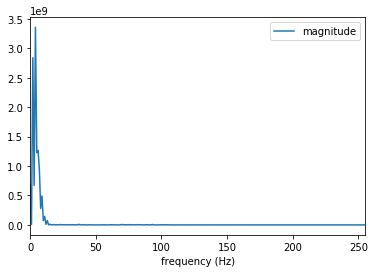

In [7]:
def to_power_spectrum (
    raw_readings: np.array,
    sampling_rate: int = 512,
) -> pd.Series:
    '''
    Take raw voltages,
    transform into frequency domain,
    return a power spectrum.
    '''
    # FFT the raw readings
    fftd = np.fft.fft(raw_readings)
    # take absolute value
    # producing a symmetrical power spectrum
    ps = np.abs(fftd)**2
    # since the power spectrum is symmetrical, 
    # take half
    half_len = len(ps)//2
    ps = ps[:half_len]
#     # we'll calculate the frequencies
    window_size = len(raw_readings)
    freqs = numpy.fft.fftfreq(window_size, d=1/sampling_rate)
#     # splitting that in half to match
    freqs = freqs[:half_len]
    power_spectrum = pd.DataFrame({
        'frequency (Hz)': freqs,
        'magnitude': ps,
    })
    return power_spectrum

ps = to_power_spectrum(dataset.raw_values[1000])
ps.plot(x='frequency (Hz)')

Now, we can see some low-frequency data, toward the left side of the graph

Let's do a "band-pass" between 0.5Hz and 20Hz, effectively "zooming in" or "cropping" to these frequencies.

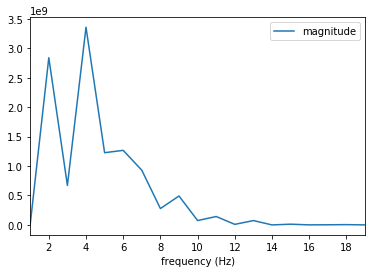

In [8]:
def bandpass (
    power_spec: pd.Series,
    low_cutoff: float,
    high_cutoff: float,
) -> pd.Series:
    return power_spec[(power_spec['frequency (Hz)'] > low_cutoff) & 
                      (power_spec['frequency (Hz)'] < high_cutoff)]

bandpass(ps, 0.5, 20).plot(x='frequency (Hz)')

Now, here's the problem: There's a bunch of other crap in the signal, too!

For example, along with the EEG signal we just saw, there's also a bunch of EMG (electromyographic) data, which is produced by the muscles in your face, or from moving your eyes!

Most of this signal will be in the *50Hz to 150Hz* range. Eyeblinks will cause big spikes in this frequency band.

### TODO
Bandpass to the EMG frequency bands, and plot them. If you want, see if you can find any readings with big spikes in this band!

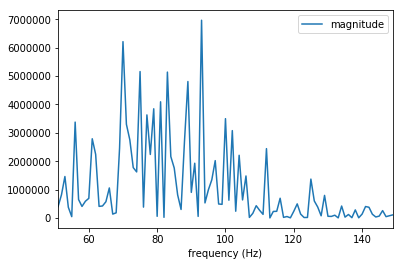

In [9]:
def bandpass (
    power_spec: pd.Series,
    low_cutoff: float,
    high_cutoff: float,
) -> pd.Series:
    return power_spec[(power_spec['frequency (Hz)'] > low_cutoff) & 
                      (power_spec['frequency (Hz)'] < high_cutoff)]

bandpass(ps, 50, 150).plot(x='frequency (Hz)')

#Spikes: Noticeable in the 90-95Hz range and 70-75Hz range
#Please note that while EMG frequency range has the range 0-500Hz, the dominant energy is in 50-150Hz
#Hence bandpass filter is used for frequency range 50-150Hz

We might also see ECG (electrocardiographic) signals, from the heart.

We'll even see background radiation from the electrical system! Here in North America, we'll see a 60Hz spike no matter what we do.

# 2. Classification

We can go crazy trying to filter all of these artifacts (and many have). 

However, we are at Berkeley, so we will take a lazy (computational) view.

We will shift our perspective in two ways, and in the end, we will not feel obligated to filter artifacts:

1. *The electromagnet is a general-purpose **biosensor***. We are sensing a multitude of human activity, including, but not limited to, EEG.

2. *Our machine learning will handle the artifacts*. If some artifacts really are artifacts (i.e., they are not informative with respect to our problem domain), then our ML will simply learn to ignore them.

`<OPTIONAL NOTE>`

These two "perspective shifts" are tightly intertwined. If you are up for it, try using the second as a lens for viewing the first. Our assumptions about EEG melt away, and we are left only with a classification problem and a signal (and the assumptions [built into those infrastructures](https://mitpress.mit.edu/books/raw-data-oxymoron) ;) ). 

We do not need to make specific commitments about what mechanisms produce the effects we are interested in. Thus, we avoid all hard epistemolgical questions (and complaints)! We are also free to discover signals that might come from unexpected places.  

If this is over your head, just remember this: If we're trying to classify interest (say), perhaps an unconscious eyebrow raise is our key signal. It would be a shame if we filtered it out, in our myopic quest for a "clean" EEG signal!

`</OPTIONAL NOTE>`

Fine, so what kind of classifier will just handle the artifacts for us?
I know, I know, you're probably thinking of neural networks. [That's an option](https://arxiv.org/pdf/1611.08024.pdf).

But, for now, we will use something much simpler, and much easier to run on your laptop: [XGBoost](https://github.com/dmlc/xgboost). You can [read up](https://xgboost.readthedocs.io/en/latest/model.html) on XGBoost on your own time, but like the FFT, you don't need to know how it works right now.

In fact, you don't even need to know what machine learning is. I will just show you an example of how to use XGBoost, and we can go from there.

First, let's make a plain, *untrained* classifier.

In [10]:
def fresh_clf () -> XGBClassifier:
    return XGBClassifier(
        # Don't worry about those parameters for now,
        # though feel free to look them up if you're interested.
        objective= 'binary:logistic',
        seed=27)

clf = fresh_clf()


Right now, this classifier is fresh to the world. It has seen no evil, heard no evil...

The "learning" part happens when our  classifier is *trained*, or *fit*, using examples. These examples have *labels*, and *features*. Our classifier will study the relationship between features and labels, so that in the future, it can map features to labels (more on this in a second).

Our **features** here are pretty clear: electromagnetic signals, our power spectra.

Our **labels** can really be anything, but for now, let's pick stuff that's easy from the existing dataset: People who are doing math, and people who are doing nothing. 

In [11]:
# All the readings during the "relax" task
relax = dataset[(dataset.label == 'relax') &
                (dataset.id == 1) ]
# All the readings taken during "math" tasks
# (Math tasks were labeled math1...math12 -
#  `math\d` is a "regular expression," or RegEx)
math = dataset[(dataset.label.str.match('math\d')) &
               (dataset.id == 1) ]

len(relax), len(math)

<input>:7: DeprecationWarning: invalid escape sequence \d
<input>:7: DeprecationWarning: invalid escape sequence \d
<input>:7: DeprecationWarning: invalid escape sequence \d
<input>:7: DeprecationWarning: invalid escape sequence \d
<input>:7: DeprecationWarning: invalid escape sequence \d
<input>:7: DeprecationWarning: invalid escape sequence \d
<input>:7: DeprecationWarning: invalid escape sequence \d
<input>:7: DeprecationWarning: invalid escape sequence \d
<input>:7: DeprecationWarning: invalid escape sequence \d
<ipython-input-11-8c139af55f28>:7: DeprecationWarning: invalid escape sequence \d
  math = dataset[(dataset.label.str.match('math\d')) &


(30, 30)

Now, we'll go about preparing our data for the classifier. 

Since our features are the power spectra, we should assemble a big collection of power spectra - and nothing else.

In [13]:
def to_features (
    df: pd.DataFrame
) -> np.array:
    power_specs = df.raw_values.apply(to_power_spectrum)
    return np.array([row.magnitude.values for row in power_specs])

Now we can make a big list of all features, with their labels removed.

In [44]:
relax_features = to_features(relax)
math_features = to_features(math)
features = np.concatenate([relax_features, math_features])
    
assert np.all( [ len(feat) == 256 for feat in features ] )

However, for each of these features, we will need corresponding labels.

Since our machine has no semantic knowledge of what these labels "mean," we will simply refer to them as 0 and 1, respectively.

In [15]:
labels = np.array([ 0 for feature in relax_features  ] \
                + [ 1 for feature in math_features ])

# list of labels should be the same 
# as the number of features
assert len(labels) == len(features)
# first label in the list should be 0
assert labels[0] == 0
# last label in the list should be 1
assert labels[-1] == 1

labels[:5], labels[-5:]

(array([0, 0, 0, 0, 0]), array([1, 1, 1, 1, 1]))

What we are left with are two matrices (numpy arrays): one of the features, and one of the labels. The labels matrix is one-dimensional. 

The features matrix can be have another dimension of any length. However, along its first dimension, it must be the same shape as the labels, so that the two align (every feature has a label).

So, here, our labels are `n x 1`, and our features are `256 x n`. (Our sampling rate is 512, producing power spectra of size 256.)


In [16]:
assert features.shape[0] == labels.shape[0]

features.shape, labels.shape

((60, 256), (60,))

By convention, we refer to the features matrix as `X` and the labels matrix as `y`. 

(I know, I know. Mathematicians have no idea how to name a variable. But, the variable names `X` and `y` are so common in literature and documentation, I feel you should be familiar with them. And thus I perpetuate the problem...)

In [85]:
X = features
y = labels

Now, we can finally train our classifier!

In [18]:
clf.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=1)

Great, we trained it! So, how does it do?

Aha, but if we've used all of our data to trian the classifier, what can we use to *test* the classifier?

We could test the classifier on the exact same stuff we trained it on, but *WE SHOULD NEVER DO THIS!!! NEVER TEST ON THE TRAIN SET!!* 

Why? The answer has to do with a concept called *overfitting*. 

> A model *overfits* to its data when it explains the data it was trained on *so exactly* that it no longer generalizes to new, unseen data. 

For example, a model may memorize the data, including noise in the data, to produce perfect accuracy. Effectively, it will memorize the data! How useful will this memorization be in classifying data it's never seen before? Not very!

To get around this, we *split* the data into train and test sets.

In [109]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, 
    # We will withold 33% of the data for the test split.
    test_size=0.33, 
    # We'll fix this parameter,
    # so that we'll always produce the same
    # "random" split on each run.* 
    random_state=42)

# (Remember, there's nothing "random" on a computer,
#  but, we do have *pseudo-*random number generators
#  (PRNGs) which are almost as good. If we fix the seed,
#  they will always generate the same sequence of numbers.
#  However, to someone who doesn't know the seeds, the
#  numbers look like white noise. Magic! You ever wonder
#  how garage door openers work? Research more
#  on your own time.)

Now we can train a *fresh* classifier on the train set,

In [110]:
clf = fresh_clf()
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=1)

and test on the test set!

In [111]:
clf.score(X_test, y_test)

0.90000000000000002

But XGBoost is even smarter than that. 

Oh yes, XGBoost is very smart. It can take some data, randomly split it into train and test sets, then see how well it does on the test set. It will use these results to tweak its parameters. Then, it can repeat this process a number of times, until it starts doing very well!


In [22]:
def xgb_cross_validate (
    X: np.array,
    y: np.array,
    nfold: int=7
) -> Tuple[XGBClassifier, pd.DataFrame]:
    # eval_metrics:
    # http://xgboost.readthedocs.io/en/latest//parameter.html
    metrics = ['error@0.1', 'auc']
#     metrics = [ 'auc' ]
    # we use the @ syntax to override the default of 0.5 as the threshold for 0 / 1 classification
    # the intent here to to minimize FAR at the expense of FRR
    alg = fresh_clf()
    xgtrain = xgb.DMatrix(X,y)
    param = alg.get_xgb_params()
    cvresults = xgb.cv(param,
                      xgtrain,
                      num_boost_round=alg.get_params()['n_estimators'],
                      nfold=nfold,
                      metrics=metrics,
                      early_stopping_rounds=100
                      )
    alg.set_params(n_estimators=cvresults.shape[0])
    alg.fit(X,y,eval_metric=metrics)
    return alg, cvresults

Now we'll now split the data into a *train* set (for which XGBoost will manage the train/test splitting), and a *validation* set, which we will use to see the results of XGBoost's efforts.

In [23]:
X_train, X_validate, y_train, y_validate = sklearn.model_selection.train_test_split(
    X, y, 
    test_size=0.33, 
    random_state=42)

clf, cvres = xgb_cross_validate(X_train, y_train)

This `cvres` value is actually a DataFrame detailing each "tweaking" step XGBoost did in training the parameters. We can inspect the last few rows to see what it did right before it delievered the classifier to us.

(If you notice in the `xgb_cross_validate` method above, we specified an `early_stopping_rounds`. We keep tweaking parametmers until the results are pretty high, or until we have tried for 100 rounds - whichever comes first).

In [24]:
cvres.tail()

,test-auc-mean,test-auc-std,test-error@0.1-mean,test-error@0.1-std,train-auc-mean,train-auc-std,train-error@0.1-mean,train-error@0.1-std
95,0.934524,0.11755,0.328571,0.201131,1.0,0.0,0.037455,0.020396
96,0.934524,0.11755,0.328571,0.201131,1.0,0.0,0.037455,0.020396
97,0.934524,0.11755,0.328571,0.201131,1.0,0.0,0.037455,0.020396
98,0.934524,0.11755,0.328571,0.201131,1.0,0.0,0.037455,0.020396
99,0.934524,0.11755,0.328571,0.201131,1.0,0.0,0.037455,0.020396


In [42]:
clf.score(X_validate, y_validate)

# All the readings during the "relax" task
relax_all = dataset[(dataset.label == 'relax')]
math_all = dataset[(dataset.label.str.match('math\d'))]
relax_all_features = to_features(relax_all)
math_all_features = to_features(math_all)
features_all = np.concatenate([relax_all_features, math_all_features])

labels_all = np.array([ 3 for feature in relax_all_features  ] \
                + [ 4 for feature in math_all_features ])

# list of labels should be the same 
# as the number of features
assert len(labels_all) == len(features_all)
# first label in the list should be 0
assert labels_all[0] == 3
# last label in the list should be 1
assert labels_all[-1] == 4

labels_all[:5], labels_all[-5:]
X_all = features_all
y_all = labels_all
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X_all, y_all, 
    # We will withold 33% of the data for the test split.
    test_size=0.33, 
    # We'll fix this parameter,
    # so that we'll always produce the same
    # "random" split on each run.* 
    random_state=42)
clf = fresh_clf()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.62459546925566345

## TODO

For how many rounds did XGBoost tweak our classifier, above, before stopping?

XGBoost tweaked our classifier for 95 rounds before stopping

What is the estimated accuracy of our classifier at distinguishing between "math" and "relax" tasks, across all subjects?

As shown in the above code, the estimated accuracy for all subjects combined comes to around 62.4%. This is with the assumption that the training data is trained for all subjects (not just one)

## TODO

In this notebook, why did our classifier do as well as it did?

In answering this question, do research, and make educated guesses based on what you learn. Optionally make arguments based on any any evidence you can collect. 

There are no right or wrong answers here. Nor is there only one answer - there are potentially a number of possible explanations! 

Some questions I always ask myself whenever I come up with explanations:

- Could I test this theory? How?
- Are there any *other* explanations? Can I test those?
- Why might the current results be misleading?

There are multiple reasons that could justify the high accuracy of our classifier:

1. The number of values also makes a difference - right now we are testing 15360 (60*256) which is a good set but not high enough - this means that choosing the split could make a difference on performance
There are two competing concerns: our parameter estimates have greater variance with less training data. With less testing data, our performance statistic will have greater variance. The next point goes deeper into how different splits could change accuracy

2. We used a good chunk of data to train the classifier (67%) and tested on the rest of it. So, the classifier was better trained. To prove this theory, I trained the classifier with different splits:

(Please run code below to verify these results)
Train%-Test%-> accuracy
10-90-> 50%
20-80 -> 68%
30-70-> 69%
50 -50 -> 86%
67-33-> 90%
80-20-> 75%
90-10-> 66%
 
With only 10% of trained data, the classifier's accuracy dropped to 50% while it was optimum at 67% of trained data. 
However, it's interesting to note that if we leave very little data to test (10%) and train 90% of it, the accuracy decreases since the total number of points to test is reduced, so the percentage factor decreases.

3. While accuracy is pretty high for subject 1, it varies for different subjects (keeping train and test data split constant) and goes as low as 30% for some of the subjects and higher than 95% for the others. So, the accuracy of the classifier could highly depend on the nature of data collected which is very subjective in this case.
(Please run the code below to generate the graph)

4. 



Code to validate point 2
Accuracy for classifier with 10% data trained::  0.5
Accuracy for classifier with 20% data trained::  0.6875
Accuracy for classifier with 30% data trained::  0.690476190476
Accuracy for classifier with 50% data trained::  0.866666666667
Accuracy for classifier with 67% data trained::  0.9
Accuracy for classifier with 80% data trained::  0.75
Accuracy for classifier with 90% data trained::  0.666666666667

Code to validate point 3
Accuracy for subject  1 :: 0.9
Accuracy for subject  2 :: 0.761904761905
Accuracy for subject  3 :: 0.9
Accuracy for subject  4 :: 0.952380952381
Accuracy for subject  5 :: 0.571428571429
Accuracy for subject  6 :: 0.55
Accuracy for subject  7 :: 0.380952380952
Accuracy for subject  8 :: 0.7
Accuracy for subject  9 :: 0.65
Accuracy for subject  10 :: 0.75
Accuracy for subject  11 :: 0.619047619048
Accuracy for subject  12 :: 0.6
Accuracy for subject  13 :: 0.85
Accuracy for subject  14 :: 0.6
Accuracy for subject  15 :: 0.55
Accuracy f

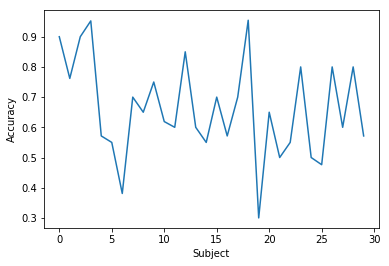


Code to validate point 4
Accuracy for subject 1 with music label added along with math and relax label reduces to:: 0.34375


In [116]:
# optionally, your code here
clf = fresh_clf()
print('Code to validate point 2')
#We train the same data with different test and train splits (0.9,0.8,0.7,0.5,0.33,0.2,0.1)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, 
    test_size=0.9,
    random_state=42)
clf.fit(X_train, y_train)
print('Accuracy for classifier with 10% data trained:: ', clf.score(X_test, y_test))

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, 
    test_size=0.8,
    random_state=42)
clf.fit(X_train, y_train)
print('Accuracy for classifier with 20% data trained:: ', clf.score(X_test, y_test))

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, 
    test_size=0.7,
    random_state=42)
clf.fit(X_train, y_train)
print('Accuracy for classifier with 30% data trained:: ', clf.score(X_test, y_test))

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, 
    test_size=0.5,
    random_state=42)
clf.fit(X_train, y_train)
print('Accuracy for classifier with 50% data trained:: ', clf.score(X_test, y_test))

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, 
    test_size=0.33,
    random_state=42)
clf.fit(X_train, y_train)
print('Accuracy for classifier with 67% data trained:: ', clf.score(X_test, y_test))

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, 
    test_size=0.2,
    random_state=42)
clf.fit(X_train, y_train)
print('Accuracy for classifier with 80% data trained:: ', clf.score(X_test, y_test))

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, 
    test_size=0.1,
    random_state=42)
clf.fit(X_train, y_train)
print('Accuracy for classifier with 90% data trained:: ', clf.score(X_test, y_test))


print('\nCode to validate point 3')

# the readings during the "relax" task
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, 
    test_size=0.33,
    random_state=42)
accuracyList = []
for i in range(1,31):
    relax_two = dataset[((dataset.label == 'relax') & (dataset.id == i))]
    math_two = dataset[((dataset.label.str.match('math\d')) & (dataset.id == i))]
    relax_two_features = to_features(relax_two)
    math_two_features = to_features(math_two)
    features_two = np.concatenate([relax_two_features, math_two_features])

    labels_two = np.array([ 3 for feature in relax_two_features  ] \
                    + [ 4 for feature in math_two_features ])

    labels_two[:5], labels_two[-5:]
    X_two = features_two
    y_two = labels_two
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
        X_two, y_two, 
        # We will withold 33% of the data for the test split.
        test_size=0.33, 
        # We'll fix this parameter,
        # so that we'll always produce the same
        # "random" split on each run.* 
        random_state=42)
    clf = fresh_clf()
    clf.fit(X_train, y_train)
    print('Accuracy for subject ', i, '::', clf.score(X_test, y_test))
    accuracyList.append(clf.score(X_test, y_test))

plt.plot(accuracyList)
plt.ylabel('Accuracy')
plt.xlabel('Subject')
plt.show()

#----------------------------------------------------------

print('\nCode to validate point 4')

# the readings during the "relax" task
relax_three = dataset[((dataset.label == 'relax') & (dataset.id == i))]
math_three = dataset[((dataset.label.str.match('math\d')) & (dataset.id == i))]
music_three = dataset[((dataset.label.str.match('music')) & (dataset.id == i))]

relax_three_features = to_features(relax_three)
math_three_features = to_features(math_three)
music_three_features = to_features(music_three)
features_three = np.concatenate([relax_three_features, math_three_features, music_three_features])

labels_three = np.array([ 3 for feature in relax_three_features  ] \
                    + [ 4 for feature in math_three_features ] + [ 5 for feature in music_three_features ])

labels_three[:5], labels_three[-5:]
X_three = features_three
y_three = labels_three
X_train_three, X_test_three, y_train_three, y_test_three = sklearn.model_selection.train_test_split(
    X_three, y_three, 
        # We will withold 33% of the data for the test split.
    test_size=0.33, 
        # We'll fix this parameter,
        # so that we'll always produce the same
        # "random" split on each run.* 
    random_state=42)
clf = fresh_clf()
clf.fit(X_train_three, y_train_three)
print('Accuracy for subject 1 with music label added along with math and relax label reduces to::', clf.score(X_test_three, y_test_three))



# Extra credit

Discover something new, and describe (or show) it below.

This graph shows the focus and attention of 4 subjects from the time of hearing a math instruction until the first math problem.      
Observation: The math problem shows up on the screen at 23.33.29 and it is that time range when the attention span of most subjects go up


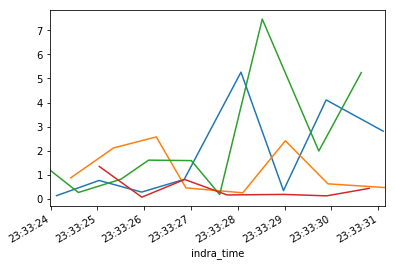

In [118]:
# your code, or words, here
# In this part, beta waves are used from eeg_power spectrum 
# to draw a trend for different subjects across different activities that took place in time

#1. This is an analysis of how attention fluctuated from the time a math instruction was given until math1 was being solved
# The different colored lines signify different subjects
labelFilter = 'mathInstruction'
labelFilter2 = 'math1'
betaForSubject1 = []
for value in dataset[(dataset.id == 1) & ((dataset.label == labelFilter)| (dataset.label == labelFilter2))].eeg_power:
    betaForSubject1.append(value[4]/value[2]) #beta wave / alpha wave ratio

ax = pd.Series(betaForSubject1, index=dataset[(dataset.id == 1) & ((dataset.label == labelFilter)| (dataset.label == labelFilter2))].index).plot()

for i in range(2,5):
    betaForSubject = []
    for value in dataset[(dataset.id == i) & ((dataset.label == labelFilter)| (dataset.label == labelFilter2))].eeg_power:
        betaForSubject.append(value[4]/value[2])
    if len(betaForSubject) > 2: #discard subjects which have less than 3 read
        pd.Series(betaForSubject, index=dataset[(dataset.id == i) & ((dataset.label == labelFilter)| (dataset.label == labelFilter2))].index).plot(ax=ax)

print('This graph shows the focus and attention of 4 subjects from the time of hearing a math instruction until the first math problem.\
      \nObservation: The math problem shows up on the screen at 23.33.29 and it is that time range when the attention span of most subjects goes up')

Observation: This graph indicates how the attention is way better while watching the video (far right) compared to solving math problem (extreme left). Please note that all values in between math and video watching have been filtered out.


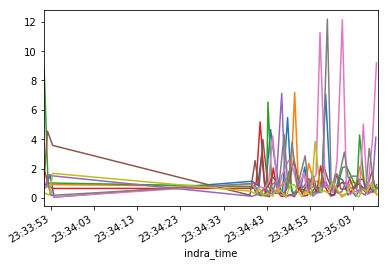

In [122]:
# 2. This graph analyses the attention span of subjects while solving math problem vs while watching a video

labelFilter = 'math10'
betaForSubject1 = []
for value in dataset[(dataset.id == 1) & ((dataset.label == labelFilter)| (dataset.label == 'video-ver1'))].eeg_power:
    betaForSubject1.append(value[4]/value[2]) #beta wave/ alpha wave

ax = pd.Series(betaForSubject1, index=dataset[(dataset.id == 1) & ((dataset.label == labelFilter)| (dataset.label == 'video-ver1'))].index).plot()

for i in range(2,10):
    betaForSubject = []
    for value in dataset[(dataset.id == i) & ((dataset.label == labelFilter)| (dataset.label == 'video-ver1'))].eeg_power:
        betaForSubject.append(value[4]/value[2]) #low beta wave/ alpha wave
    if len(betaForSubject) > 2: #discard subjects which have less than 3 read
        pd.Series(betaForSubject, index=dataset[(dataset.id == i) & ((dataset.label == labelFilter)| (dataset.label == 'video-ver1'))].index).plot(ax=ax)

print('Observation: This graph indicates how the attention is way better while watching the video (far right) compared to solving math problem (extreme left). Please note that all values in between math and video watching have been filtered out.')

Obeservation: The magnitude of relaxation increases when you are listening to music (extreme right) vs doing math


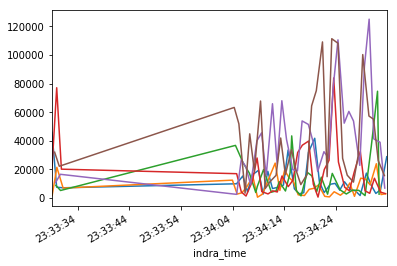

In [124]:
# 3. This graph tries to find a relaxation pattern when subjects are doing math vs listening to music using alpha waves
# which are activated during relaxed state

labelFilter = 'math1'
betaForSubject1 = []
for value in dataset[(dataset.id == 1) & ((dataset.label == labelFilter)| (dataset.label == 'music'))].eeg_power:
    betaForSubject1.append(value[2]) #low alpha wave

ax = pd.Series(betaForSubject1, index=dataset[(dataset.id == 1) & ((dataset.label == labelFilter)| (dataset.label == 'music'))].index).plot()

for i in range(2,7):
    betaForSubject = []
    for value in dataset[(dataset.id == i) & ((dataset.label == labelFilter)| (dataset.label == 'music'))].eeg_power:
        betaForSubject.append(value[2]) #low alpha wave
    if len(betaForSubject) > 2: #discard subjects which have less than 3 read
        pd.Series(betaForSubject, index=dataset[(dataset.id == i) & ((dataset.label == labelFilter)| (dataset.label == 'music'))].index).plot(ax=ax)

print('Obeservation: The magnitude of relaxation increases when you are listening to music (extreme right) vs doing math (left)')

Observation: This graph looks at how beta wave has a spike at almost every math question presented for a particular subject


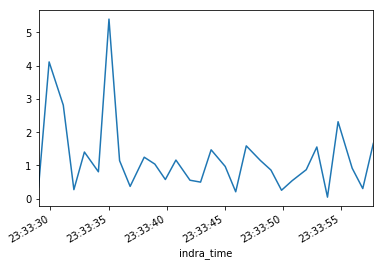

In [130]:
#4. This graph looks at how beta wave has a spike at almost every math question presented for a particular subject
labelFilter = 'math\d'
betaForSubject1 = []

for value in dataset[(dataset.id == 1) & (dataset.label.str.match('math\d'))].eeg_power:
    betaForSubject1.append(value[4]/value[2]) #low beta wave

ax = pd.Series(betaForSubject1, index=dataset[(dataset.id == 1) & (dataset.label.str.match('math\d'))].index).plot()

for i in range(2,8):
    betaForSubject = []
    for value in dataset[(dataset.id == i) & (dataset.label == labelFilter)].eeg_power:
        betaForSubject.append(value[4]/value[2]) #low beta wave
    if len(betaForSubject) > 2: #discard subjects which have less than 3 read
        pd.Series(betaForSubject, index=dataset[(dataset.id == i) & (dataset.label.str.match('math\d'))].index).plot(ax=ax)

print('Observation: This graph looks at how beta wave has a spike at almost every math question presented for a particular subject')